## Import Libraries

In [1]:
# To ignore warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("../cleaned/clean_data.csv")

In [95]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 10754 non-null  object 
 1   name                 10754 non-null  object 
 2   position             10754 non-null  object 
 3   height               10754 non-null  float64
 4   age                  10754 non-null  float64
 5   appearance           10754 non-null  int64  
 6   goals                10754 non-null  float64
 7   assists              10754 non-null  float64
 8   yellow cards         10754 non-null  float64
 9   second yellow cards  10754 non-null  float64
 10  red cards            10754 non-null  float64
 11  goals conceded       10754 non-null  float64
 12  clean sheets         10754 non-null  float64
 13  minutes played       10754 non-null  int64  
 14  days_injured         10754 non-null  int64  
 15  games_injured        10754 non-null 

In [96]:
df["position_encoded"].value_counts()

position_encoded
2    3528
3    3095
4    2902
1    1229
Name: count, dtype: int64

In [97]:
df["position"].value_counts()

position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64

In [98]:
df.head(2)

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

<p style="color:blue">We have already conducted the EDA in EDA NoteBook</p>

In [99]:
df[df.duplicated()]

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [100]:
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [101]:
df["position_encoded"]

0        1
1        1
2        1
3        2
4        2
        ..
10749    4
10750    4
10751    4
10752    4
10753    4
Name: position_encoded, Length: 10754, dtype: int64

In [102]:
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [103]:
df.drop(["position","team","name"], axis=1, inplace=True)
# select features columns
categorical_features = list(df.select_dtypes(object).columns)
numeric_features = list(df.select_dtypes('number'))

# remove encoded columns


# removing this increased the r2 score but idk if this is luck (need more checking)
numeric_features.remove("highest_value")


print(categorical_features)
print(numeric_features)

[]
['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'position_encoded', 'winger']


In [104]:
for i in categorical_features:
    print (df[i].value_counts())

In [105]:
# all good for categorical data

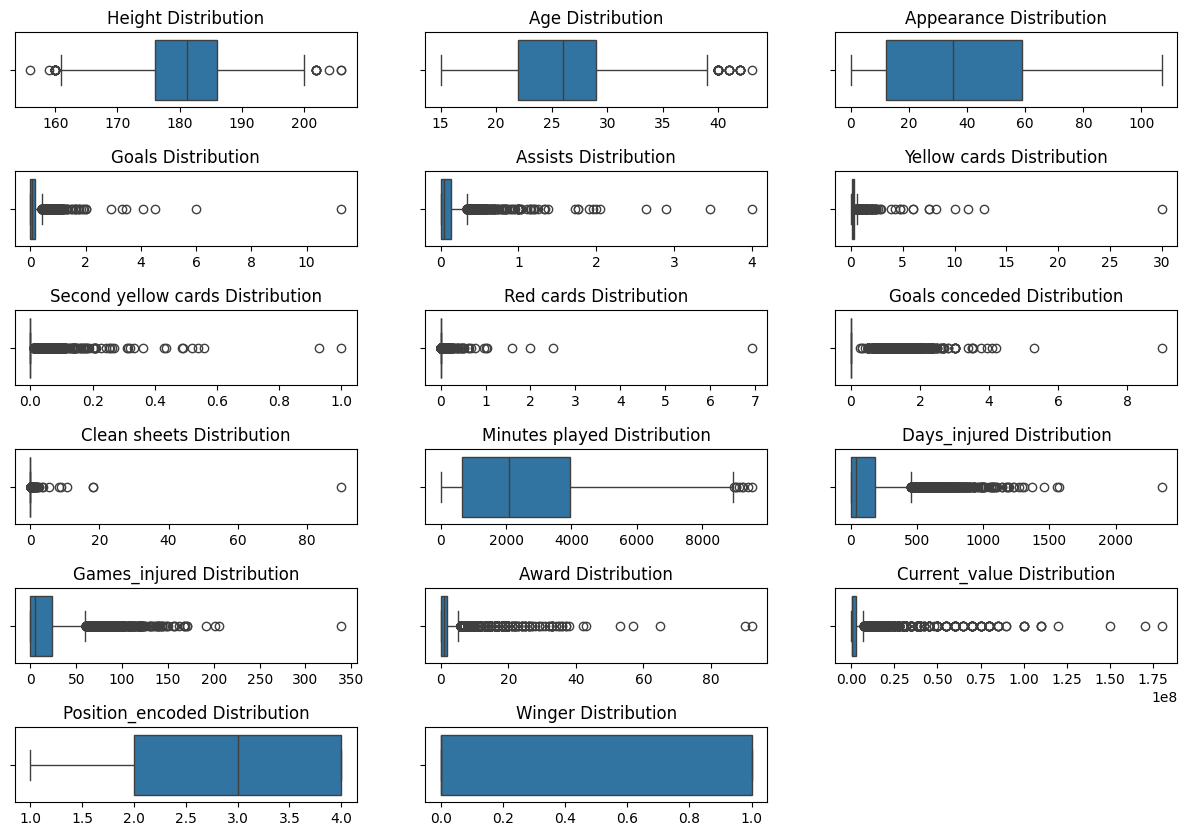

In [106]:
def plot_outliers(df: pd.DataFrame, features: list[str]) -> None:
    """
    Plots boxplots to show outliers for specified features in a DataFrame.
    
    param df: pd.DataFrame
    param features: list[str]
    
    return: None
    """
    # determine the number of rows needed for subplots
    n_rows: int = (len(features) + 2) // 3
    
    # create figure for subplots
    plt.figure(figsize=(15, 10))
    
    # plot each feature as a boxplot to show outliers
    for i, column in enumerate(features, 1):
        # add subplot
        plt.subplot(n_rows, 3, i)
        
        # create boxplot
        sns.boxplot(x=df[column])
        
        # set plot title and labels
        plt.title(f'{column.capitalize()} Distribution')
        plt.xlabel('')
        
        # add space between plots for clarity
        plt.subplots_adjust(hspace=0.85)
    
    # show plots
    plt.show()
    
plot_outliers(df, numeric_features)

In [107]:
# here we can see that there is many outliers and in our case 
# the Linear Regression is sensitive to outliers so we need a way to deal with the outlier, here are some:
# Z-Score
# IQR
# we will be using IQR

In [108]:
def remove_outliers_iqr(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.
    
    param data: pd.DataFrame
    param columns: list[str]
    
    return: pd.DataFrame
    """
    # iterate over each column to remove outliers
    for column in columns:
        # calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        
        # calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # filter out outliers
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [109]:
def remove_outliers_zscore(df: pd.DataFrame, columns: list[str], threshold: float = 3.0) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.
    
    param df: pd.DataFrame - The input data.
    param columns: list[str] - The list of columns to check for outliers.
    param threshold: float - The Z-score threshold for identifying outliers.
    
    return: pd.DataFrame - The DataFrame with outliers removed.
    """
    # calculate Z-scores
    z_scores = np.abs(df[columns].apply(zscore))

    # filter out outliers
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    
    return filtered_df

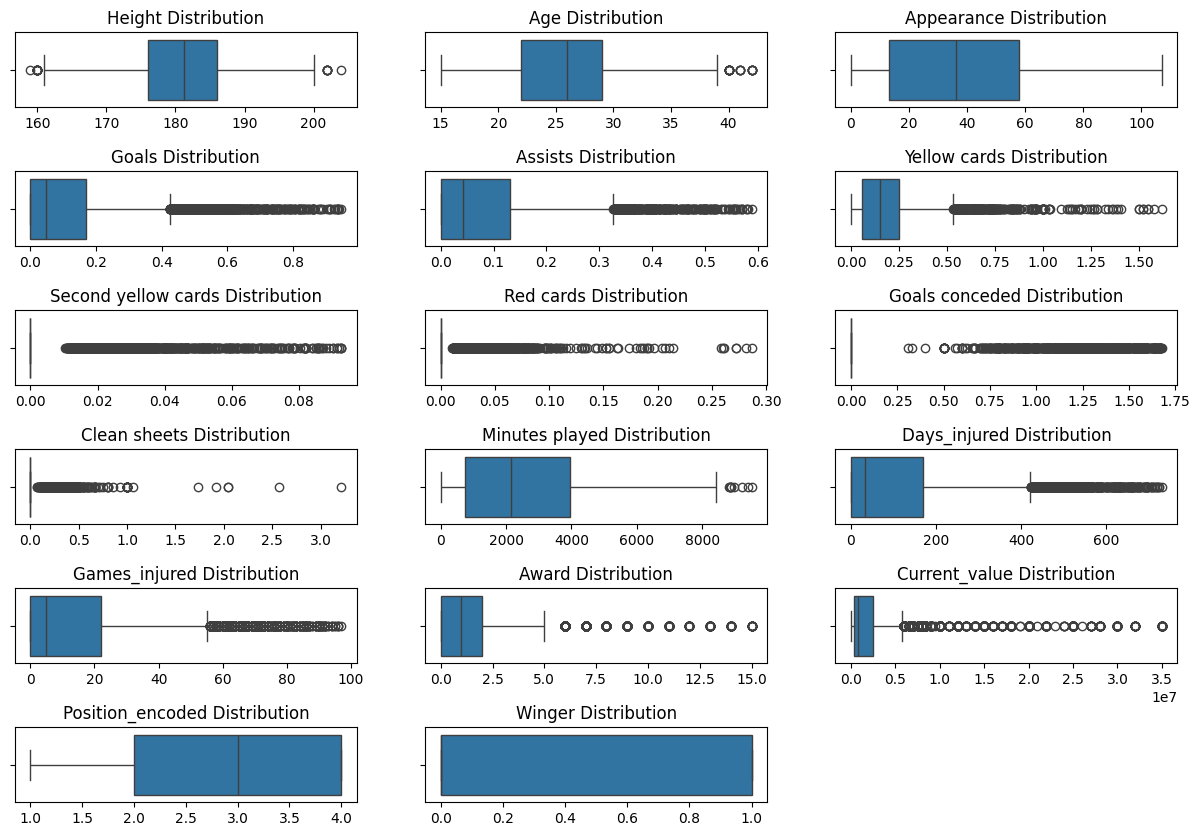

Original vs IQR: (10754, 18) vs (9855, 18) 


In [110]:
# filter outlier
filtered_data = remove_outliers_zscore(df, numeric_features, 3.5)

# plot to compare
plot_outliers(filtered_data, numeric_features)
print(f"Original vs IQR: {df.shape} vs {filtered_data.shape} ")

In [111]:
# here we can see that the outliers are better by visualization (some data are too small need check)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [112]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [113]:
categorical_features

[]

In [114]:
df.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value', 'position_encoded', 'winger'],
      dtype='object')

In [115]:
display(df.head(2))
df.shape

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


(10754, 18)

#### 3. Feature selection

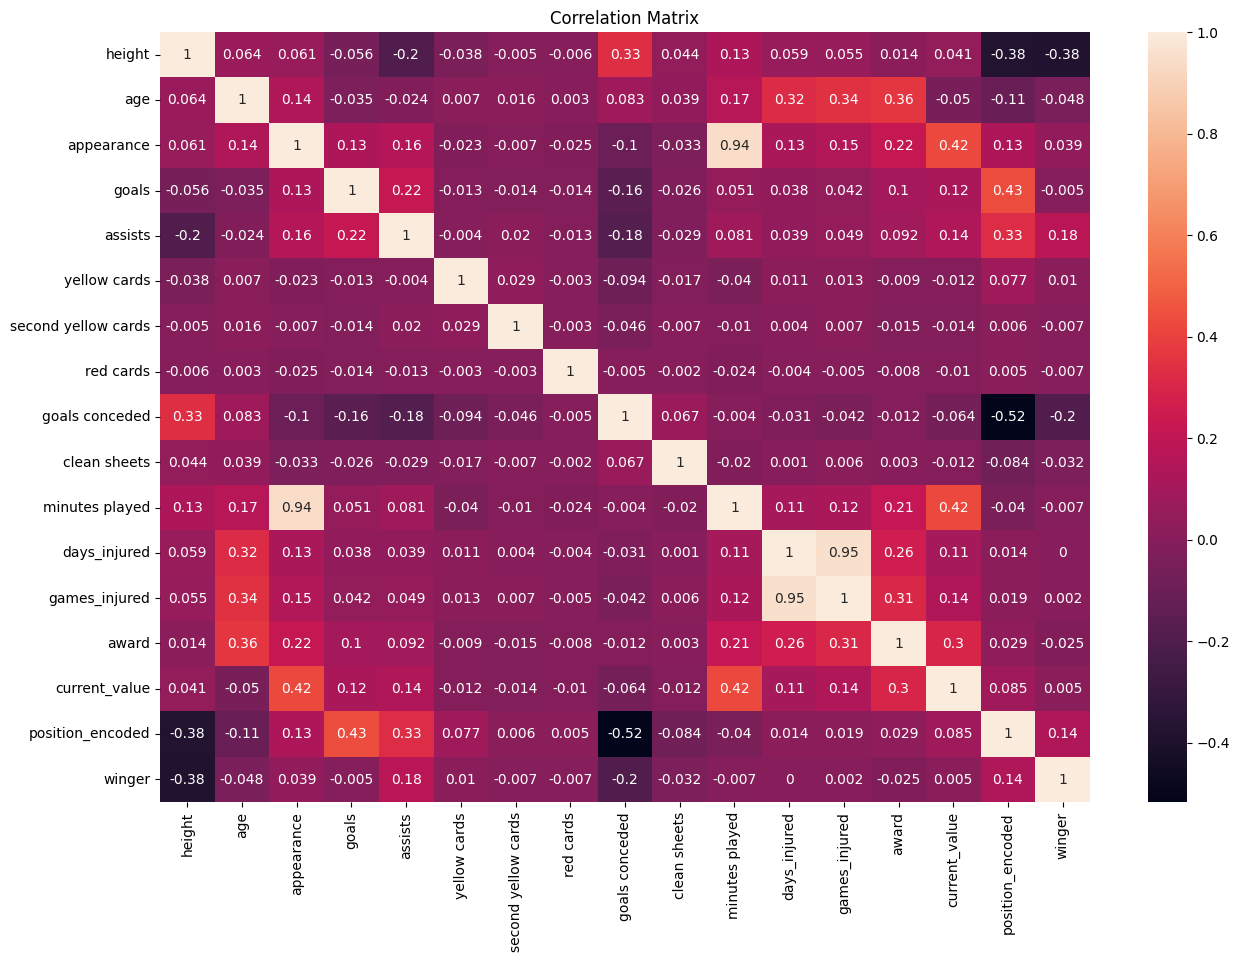

position_encoded       1.000000
goals                  0.434600
assists                0.324714
winger                 0.144111
appearance             0.129357
current_value          0.085154
yellow cards           0.077185
award                  0.029111
games_injured          0.019375
days_injured           0.013889
second yellow cards    0.005766
red cards              0.004614
minutes played         0.039969
clean sheets           0.084334
age                    0.107469
height                 0.378333
goals conceded         0.517020
Name: position_encoded, dtype: float64


In [116]:
cor = df[numeric_features].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(round(df[numeric_features].corr(),3), annot=True)
plt.title('Correlation Matrix')
plt.show()

print(abs(cor['position_encoded'].sort_values(ascending=False)))

In [117]:
# Set the correlation threshold
threshold = 0.03  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = cor[abs(cor['position_encoded']) > threshold]\
    ['position_encoded'].index
selected_features

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'goals conceded', 'clean sheets', 'minutes played', 'current_value',
       'position_encoded', 'winger'],
      dtype='object')

In [118]:
df[selected_features].head(2)

,height,age,appearance,goals,assists,yellow cards,goals conceded,clean sheets,minutes played,current_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,1.217252,0.335463,9390,15000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,1.242331,0.207055,1304,1500000,1,0


In [119]:
df['position_encoded'].value_counts()

position_encoded
2    3528
3    3095
4    2902
1    1229
Name: count, dtype: int64

#### 4. Prepare train and test data

In [120]:
# Prepare data
X = df[selected_features].drop(["position_encoded"], axis=1)
y = df['position_encoded']

In [121]:
X

,height,age,appearance,goals,assists,yellow cards,goals conceded,clean sheets,minutes played,current_value,winger
0,189.000000,32.0,104,0.000000,0.000000,0.009585,1.217252,0.335463,9390,15000000,0
1,196.000000,30.0,15,0.000000,0.000000,0.069018,1.242331,0.207055,1304,1500000,0
2,188.000000,37.0,4,0.000000,0.000000,0.000000,0.616438,0.924658,292,600000,0
3,175.000000,25.0,82,0.028090,0.056180,0.224719,0.000000,0.000000,6408,50000000,0
4,191.000000,30.0,63,0.017889,0.017889,0.053667,0.000000,0.000000,5031,40000000,0
...,...,...,...,...,...,...,...,...,...,...,...
10749,181.240353,20.0,16,0.175953,0.087977,0.263930,0.000000,0.000000,1023,75000,1
10750,190.000000,24.0,26,0.372671,0.186335,0.186335,0.000000,0.000000,1449,300000,0
10751,181.240353,19.0,20,0.375000,0.000000,0.187500,0.000000,0.000000,960,50000,0
10752,181.240353,20.0,17,0.312139,0.104046,0.000000,0.000000,0.000000,865,50000,0


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [123]:
svm_classifier = SVC(verbose=10)

In [124]:
# here i just used small set of hyperparameters to save time 
param_grid = {
    'kernel': ['linear', 'rbf'],   # Regularization strength
    'C': list(range(18,26,1)),
    'gamma': list(np.arange(0.01,0.11,0.02))
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1_macro', 
                           verbose=10)

## Train the Model

In [125]:
# here we took small sample due to time limitations nad the nature of svm with large data
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[LibSVM]

GridSearchCV(cv=5, estimator=SVC(verbose=10), n_jobs=-1,
             param_grid={'C': [18, 19, 20, 21, 22, 23, 24, 25],
                         'gamma': [0.01, 0.03, 0.049999999999999996,
                                   0.06999999999999999, 0.08999999999999998],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=10)

In [126]:
grid_search.best_params_

{'C': 21, 'gamma': 0.03, 'kernel': 'rbf'}

In [127]:
best_model = grid_search.best_estimator_


## Test the Model

In [128]:
y_pred_rf_g = best_model.predict(X_test)

c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Interpretation of the Model

In [129]:
# our benchmark model
base_model = round(df['position_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

11.43

## Evaluating the Model 

In [130]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy


0.2701069270106927

In [131]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy


c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.2697896082761827

In [132]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[  0,   0,   0, 257],
       [  0,   0,   0, 693],
       [  0,   0,   0, 620],
       [  0,   0,   0, 581]], dtype=int64)

In [133]:
print(classification_report(y_test,
                      y_pred_rf_g,
                      labels=list(best_model.classes_)))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       257
           2       0.00      0.00      0.00       693
           3       0.00      0.00      0.00       620
           4       0.27      1.00      0.43       581

    accuracy                           0.27      2151
   macro avg       0.07      0.25      0.11      2151
weighted avg       0.07      0.27      0.11      2151



c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

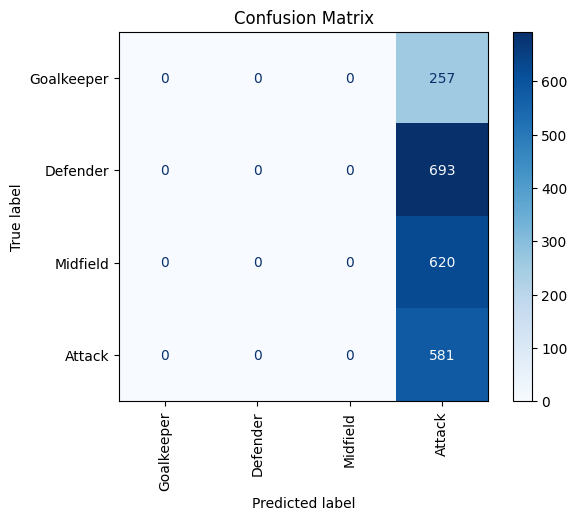

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# dictionary for label names
labels = {1: "Goalkeeper", 2: "Defender", 3: "Midfield", 4: "Attack"}

# display confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf_g,
    display_labels=[labels[i] for i in list(best_model.classes_)], 
    cmap="Blues",
    xticks_rotation='vertical'
)

# set title for the plot
plt.title('Confusion Matrix')

# show the plot
plt.show()

In [135]:
# Calculate Precision
precision = precision_score(y_test, y_pred_rf_g, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.07


c:\Users\Reyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [136]:
# Calculate Recall
recall = recall_score(y_test, y_pred_rf_g, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.25


In [137]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.11
